# KISS GPs with Digital Sequences

https://arxiv.org/pdf/1503.01057

$$\renewcommand{\mK}{{\mathsf{K}}}$$
$$\renewcommand{\mX}{{\mathsf{X}}}$$
$$\renewcommand{\mU}{{\mathsf{U}}}$$
$$\renewcommand{\mW}{{\mathsf{W}}}$$

$$\mK_{\mX,\mX} \approx \mK_{\mX,\mU} \mK_{\mU,\mU}^{-1} \mK_{\mU,\mX} \approx \mW \mK_{\mU,\mU} \mK_{\mU,\mU}^{-1} \mK_{\mU,\mU} \mW^\intercal  = \mW \mK_{\mU,\mU} \mW^\intercal$$

$$\varepsilon_1 = \frac{\lVert \mK_{\mX,\mX} - \mK_{\mX,\mU} \mK_{\mU,\mU}^{-1} \mK_{\mU,\mX} \rVert_F}{\lVert \mK_{\mX,\mX} \rVert_F}$$

$$\varepsilon_2 = \frac{\lVert \mK_{\mX,\mX} - \mW \mK_{\mU,\mU} \mW^\intercal \rVert_F}{\lVert \mK_{\mX,\mX} \rVert_F}$$

## Setup

In [1]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np 
import scipy.stats
import qmcpy as qp
import matplotlib
from matplotlib import pyplot
pyplot.style.use("seaborn-v0_8-whitegrid")
import pandas as pd
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#",header=None).iloc[:,0].tolist()][::-1]
# pyplot.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)
LINESTYLES = ['solid','dotted','dashed','dashdot',(0, (1, 1))]
DEFAULTFONTSIZE = 30
pyplot.rcParams['xtick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['axes.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams['figure.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams["axes.labelsize"] = DEFAULTFONTSIZE
pyplot.rcParams['legend.fontsize'] = DEFAULTFONTSIZE
pyplot.rcParams['font.size'] = DEFAULTFONTSIZE
pyplot.rcParams['lines.linewidth'] = 5
pyplot.rcParams['lines.markersize'] = 15
PW = 30 # inches

## Data points and inducing points

x.shape = (100, 2)
u.shape = (256, 2)


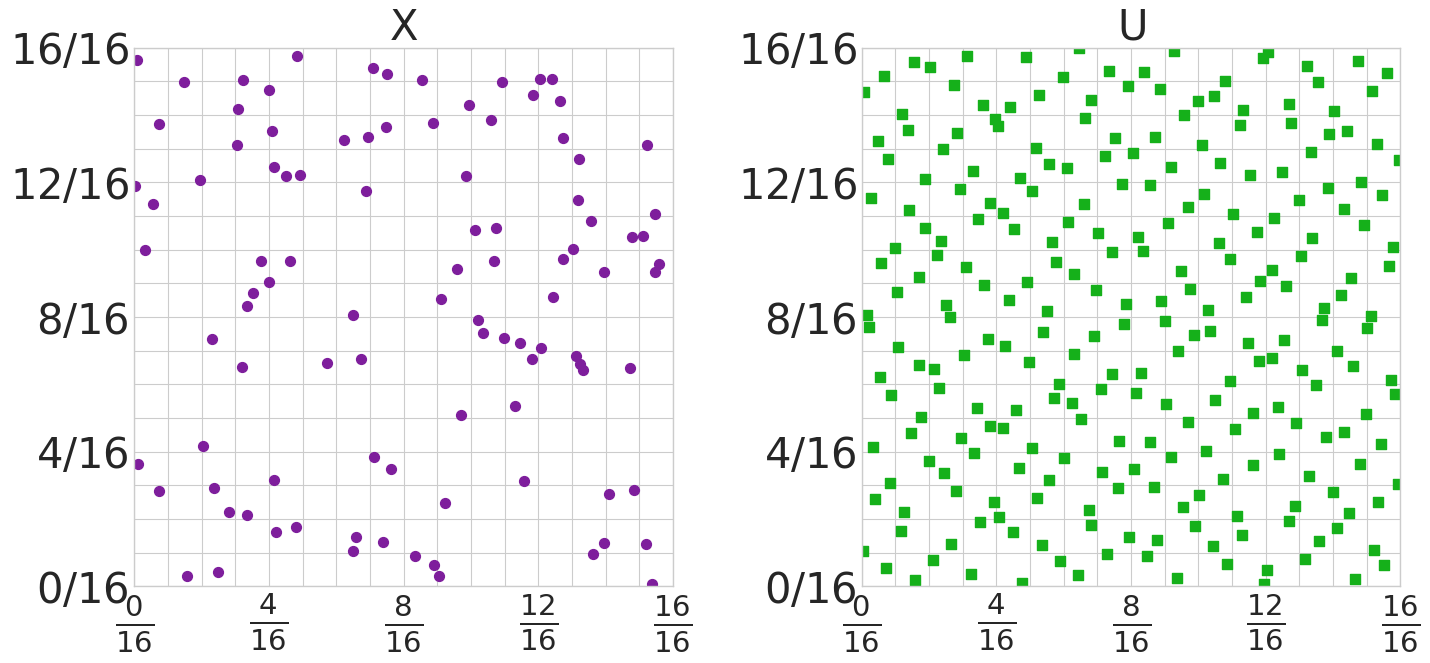

In [53]:
d = 2
rng = torch.Generator().manual_seed(11)
n = 100
m = 8
assert m%2==0, "m must be even"
x = torch.rand(n,d,generator=rng)
print("x.shape = %s"%str(tuple(x.shape)))
dnb2 = qp.DigitalNet(d,seed=11) # with d=2 this is a (0,m,d) sequence
u = torch.from_numpy(dnb2(2**m))
print("u.shape = %s"%str(tuple(u.shape)))
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(PW/2,PW/4))
ax[0].scatter(x[:,0],x[:,1],s=50,color=COLORS[0],marker='o')
ax[0].set_title(r"$\mathsf{X}$")
ax[1].scatter(u[:,0],u[:,1],s=50,color=COLORS[1],marker='s')
ax[1].set_title(r"$\mathsf{U}$")
for i in range(2):
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].set_aspect(1)
    ax[i].set_xticks(torch.arange(2**(m/2)+1)/2**(m/2))
    ax[i].set_yticks(torch.arange(2**(m/2)+1)/2**(m/2))
    ax[i].set_xticklabels([r"$\frac{%d}{%d}$"%(i,2**(m//2)) if i/2**(m//2) in [0,1/4,1/2,3/4,1] else "" for i in range(2**(m//2)+1)])
    ax[i].set_yticklabels([r"$%d/%d$"%(i,2**(m//2)) if i/2**(m//2) in [0,1/4,1/2,3/4,1] else "" for i in range(2**(m//2)+1)])
fig.tight_layout()

## Kernel matrices

k_xx.shape = (100, 100)
k_xu.shape = (100, 256)
k_uu.shape = (256, 256)


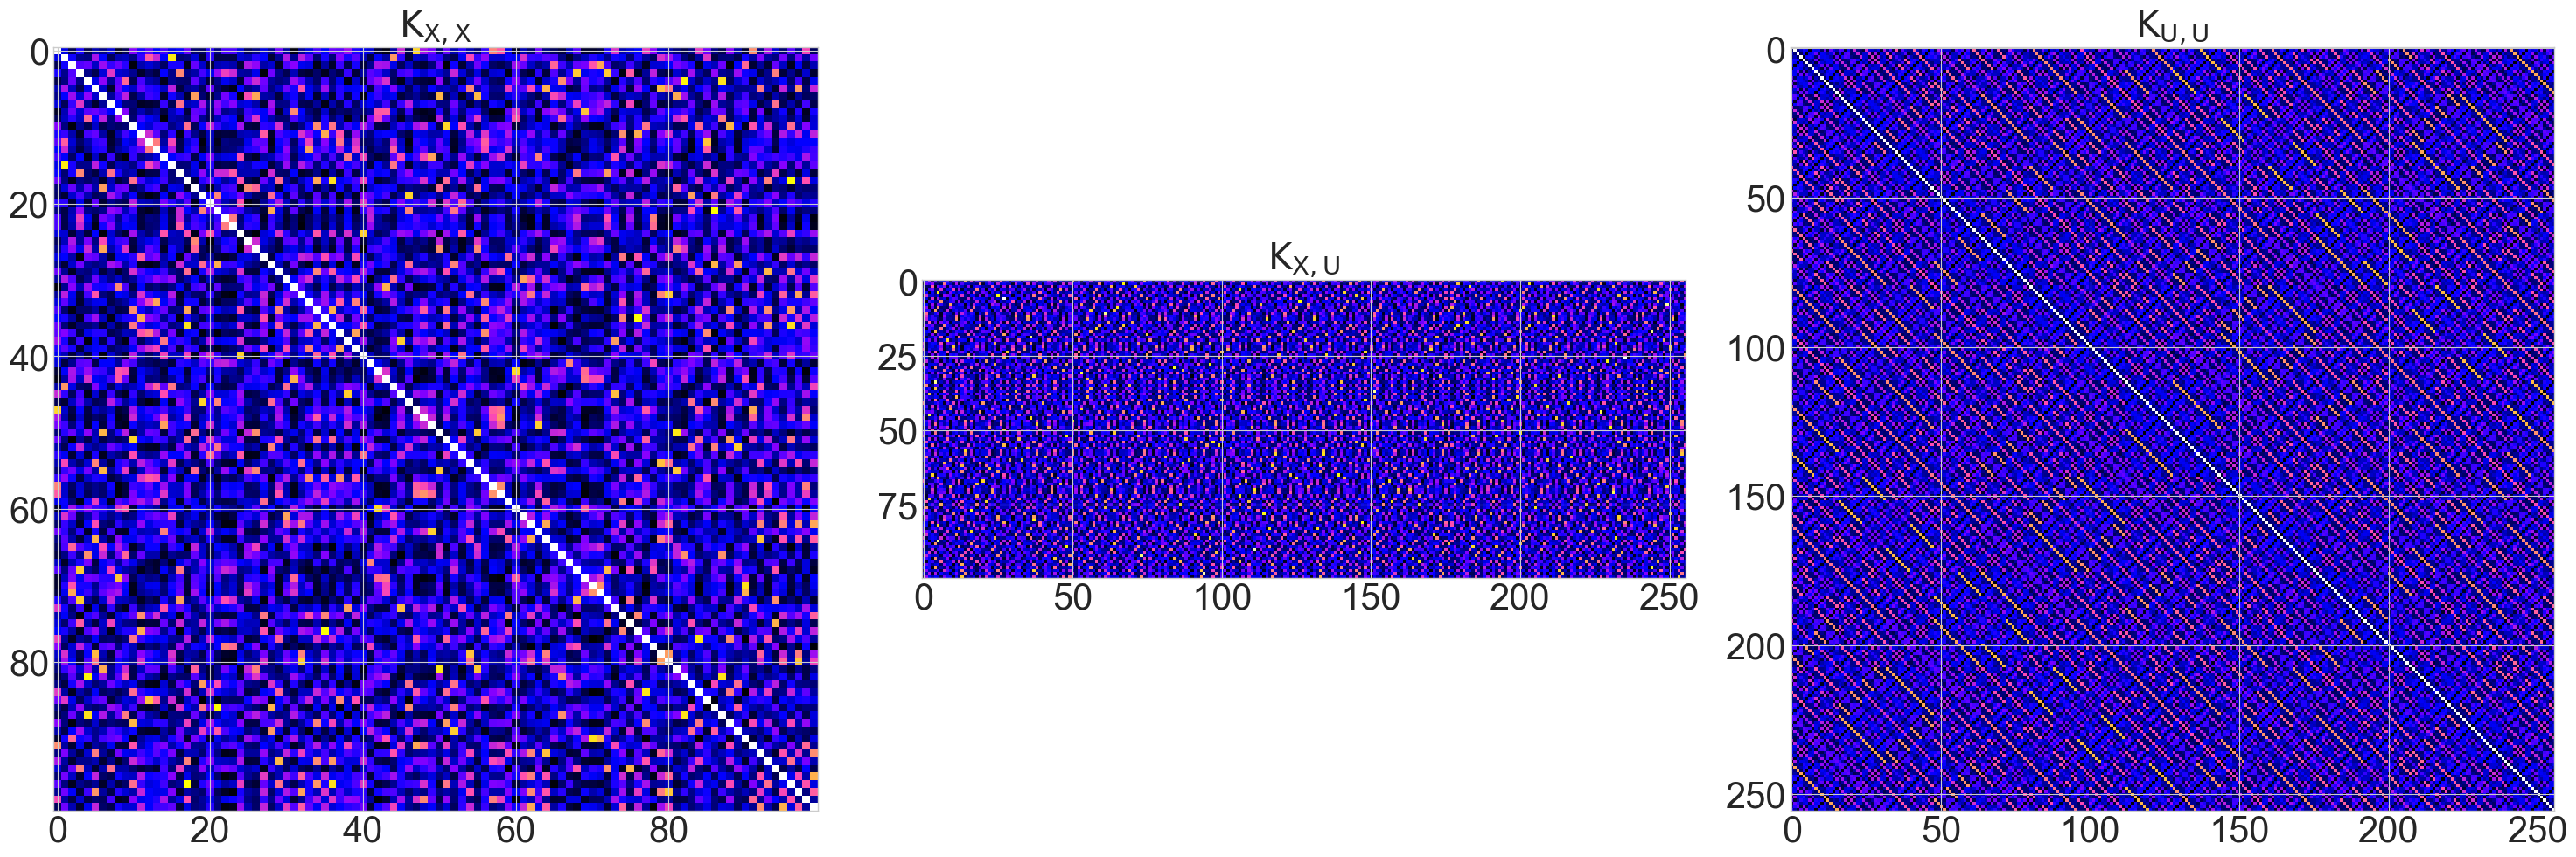

In [54]:
kernel = qp.KernelDigShiftInvar(d,torchify=True,t=dnb2.t)
k_xx = kernel(x[:,None,:],x[None,:,:]).detach()
print("k_xx.shape = %s"%str(tuple(k_xx.shape)))
k_xu = kernel(x[:,None,:],u[None,:,:]).detach()
print("k_xu.shape = %s"%str(tuple(k_xu.shape)))
k_uu = kernel(u[:,None,:],u[None,:,:]).detach()
print("k_uu.shape = %s"%str(tuple(k_uu.shape)))
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(PW,PW/3))
ax[0].imshow(k_xx,cmap="gnuplot2")
ax[0].set_title(r"$\mathsf{K}_{\mathsf{X},\mathsf{X}}$")
ax[1].imshow(k_xu,cmap="gnuplot2")
ax[1].set_title(r"$\mathsf{K}_{\mathsf{X},\mathsf{U}}$")
ax[2].imshow(k_uu,cmap="gnuplot2")
ax[2].set_title(r"$\mathsf{K}_{\mathsf{U},\mathsf{U}}$")
fig.tight_layout()

## Nearest neighbor 

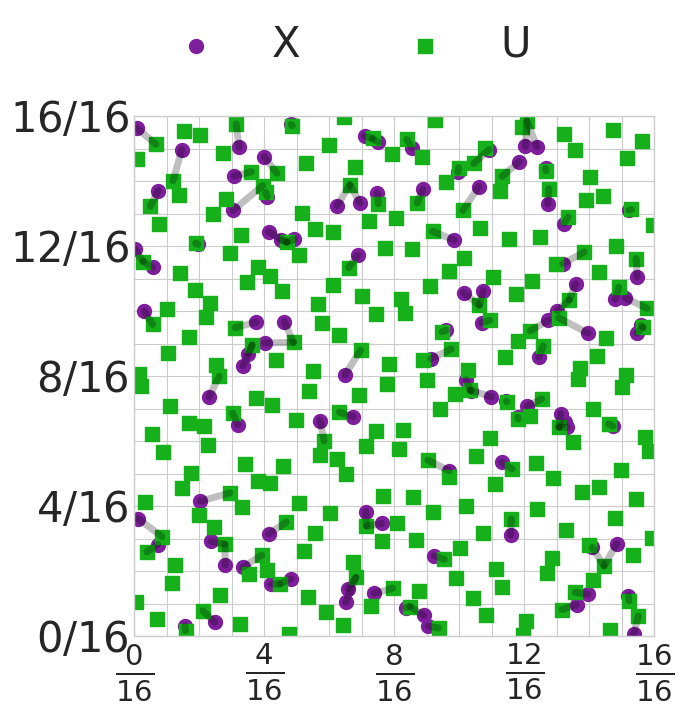

In [55]:
map_u = {(int(j1*2**(m//2)),int(j2*2**(m//2))): i for i,(j1,j2) in enumerate(u)}
w = torch.tensor([map_u[(int(j1*2**(m//2)),int(j2*2**(m//2)))] for j1,j2 in x],dtype=int)
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(PW/4,PW/4))
ax.scatter(x[:,0],x[:,1],s=100,color=COLORS[0],marker='o',label=r"$\mathsf{X}$")
ax.scatter(u[:,0],u[:,1],s=100,color=COLORS[1],marker='s',label=r"$\mathsf{U}$")
for i in range(n):
    u_i = u[w[i]]
    ax.plot([x[i,0],u_i[0]],[x[i,1],u_i[1]],color="k",alpha=0.25)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_aspect(1)
ax.set_xticks(torch.arange(2**(m/2)+1)/2**(m/2))
ax.set_yticks(torch.arange(2**(m/2)+1)/2**(m/2))
ax.set_xticklabels([r"$\frac{%d}{%d}$"%(i,2**(m//2)) if i/2**(m//2) in [0,1/4,1/2,3/4,1] else "" for i in range(2**(m//2)+1)])
ax.set_yticklabels([r"$%d/%d$"%(i,2**(m//2)) if i/2**(m//2) in [0,1/4,1/2,3/4,1] else "" for i in range(2**(m//2)+1)])
fig.legend(frameon=False,bbox_to_anchor=(0.8,1.05),ncols=2)
fig.tight_layout()

## Approximate Gram matrices

In [56]:
norm_k_xx = torch.linalg.norm(k_xx)
g_kiss1 = k_xu@torch.linalg.solve(k_uu,k_xu.T) # SOR
g_kiss1[torch.arange(n),torch.arange(n)] = k_xx[torch.arange(n),torch.arange(n)] # uncomment for FITC 
eps1 = torch.linalg.norm(k_xx-g_kiss1)/norm_k_xx
print("eps1 = %.2e"%eps1)
g_kiss2 = k_uu[w,:][:,w]
g_kiss2[torch.arange(n),torch.arange(n)] = k_xx[torch.arange(n),torch.arange(n)] # uncomment for FITC 
eps2 = torch.linalg.norm(k_xx-g_kiss2)/norm_k_xx
print("eps2 = %.2e"%eps2)

eps1 = 1.30e-02
eps2 = 3.73e-02


## Function approximation with GPs

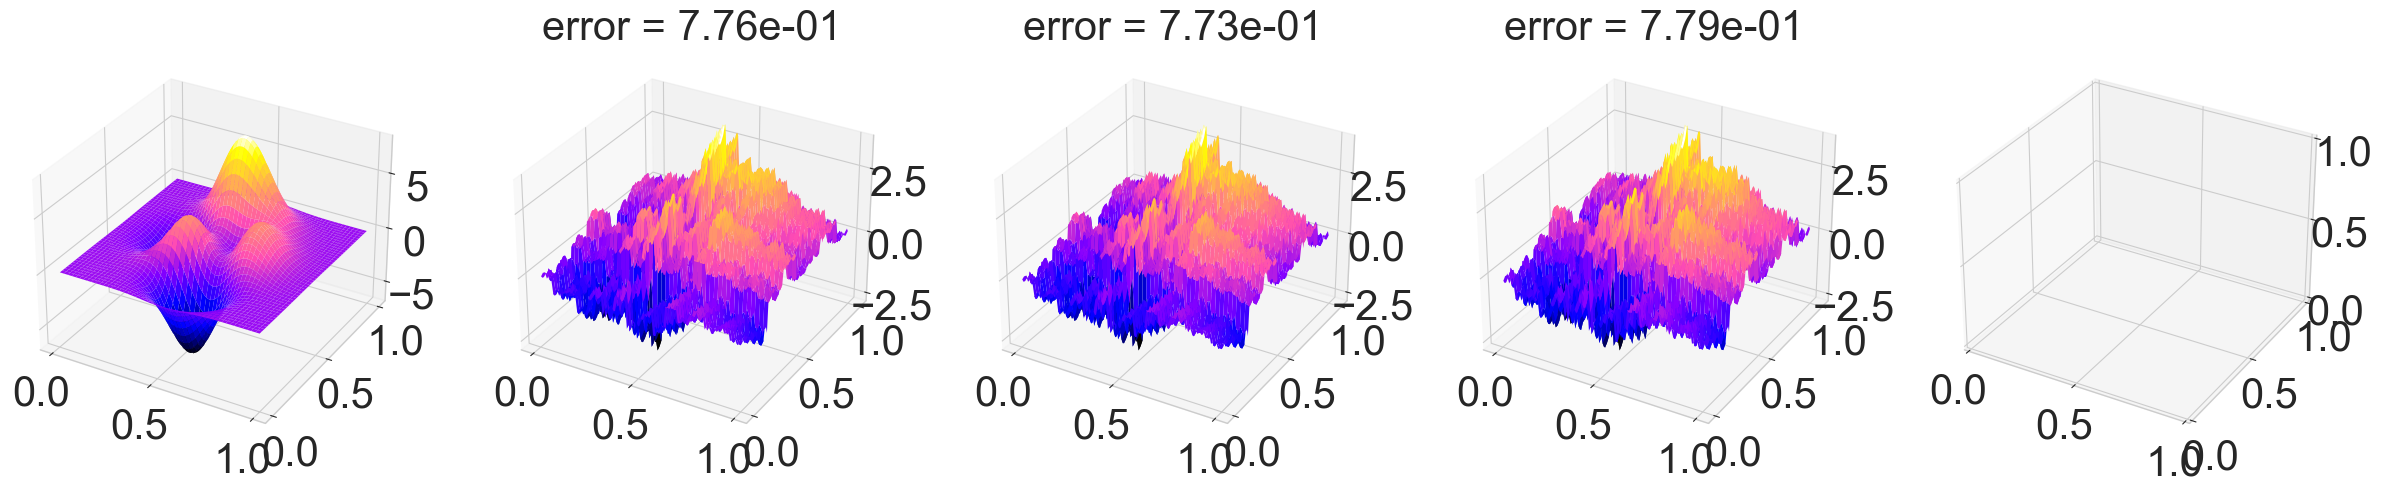

In [57]:
def f(x):
    assert x.size(-1)==2
    x = 6*x-3 
    x0,x1 = x[...,0],x[...,1]
    y = 3*(1-x0)**2*torch.exp(-x0**2-(x1+1)**2)-10*(x0/5-x0**3-x1**5)*torch.exp(-x0**2-x1**2)-1/3*torch.exp(-(x0+1)**2-x1**2)
    return y
xticks_1d = torch.linspace(0,1,101)[1:-1]
x0mesh,x1mesh = torch.meshgrid(xticks_1d,xticks_1d,indexing="ij")
xticks = torch.stack([x0mesh.flatten(),x1mesh.flatten()],axis=1)
yticks = f(xticks) 
y = f(x)
eps = 1e0
k_xticks_x = kernel(xticks[:,None,:],x).detach()
alpha_gp = torch.linalg.solve(k_xx+eps*torch.eye(n),y[:,None])[:,0].detach()
yhatticks_gp = k_xticks_x@alpha_gp
l2rerror_gp = torch.linalg.norm(yticks-yhatticks_gp)/torch.linalg.norm(yticks)
alpha_kiss1 = torch.linalg.solve(g_kiss1+eps*torch.eye(n),y[:,None])[:,0].detach()
yhatticks_kiss1 = k_xticks_x@alpha_kiss1
l2rerror_kiss1 = torch.linalg.norm(yticks-yhatticks_kiss1)/torch.linalg.norm(yticks)
alpha_kiss2 = torch.linalg.solve(g_kiss2+eps*torch.eye(n),y[:,None])[:,0].detach()
yhatticks_kiss2 = k_xticks_x@alpha_kiss2
l2rerror_kiss2 = torch.linalg.norm(yticks-yhatticks_kiss2)/torch.linalg.norm(yticks)
fig,ax = pyplot.subplots(1,5,subplot_kw={'projection':'3d'},figsize=(PW,PW))
ax[0].plot_surface(x0mesh,x1mesh,yticks.reshape(x0mesh.shape),cmap="gnuplot2");
ax[1].plot_surface(x0mesh,x1mesh,yhatticks_gp.reshape(x0mesh.shape),cmap="gnuplot2");
ax[2].plot_surface(x0mesh,x1mesh,yhatticks_kiss1.reshape(x0mesh.shape),cmap="gnuplot2");
ax[3].plot_surface(x0mesh,x1mesh,yhatticks_kiss2.reshape(x0mesh.shape),cmap="gnuplot2");
ax[1].set_title(r"error = %.2e"%l2rerror_gp)
ax[2].set_title(r"error = %.2e"%l2rerror_kiss1)
ax[3].set_title(r"error = %.2e"%l2rerror_kiss2);